In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"

HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
#     print(os.listdir(housing_path))

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()
housing.head()
housing.info()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [12]:
housing.ocean_proximity.value_counts()
housing.describe()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

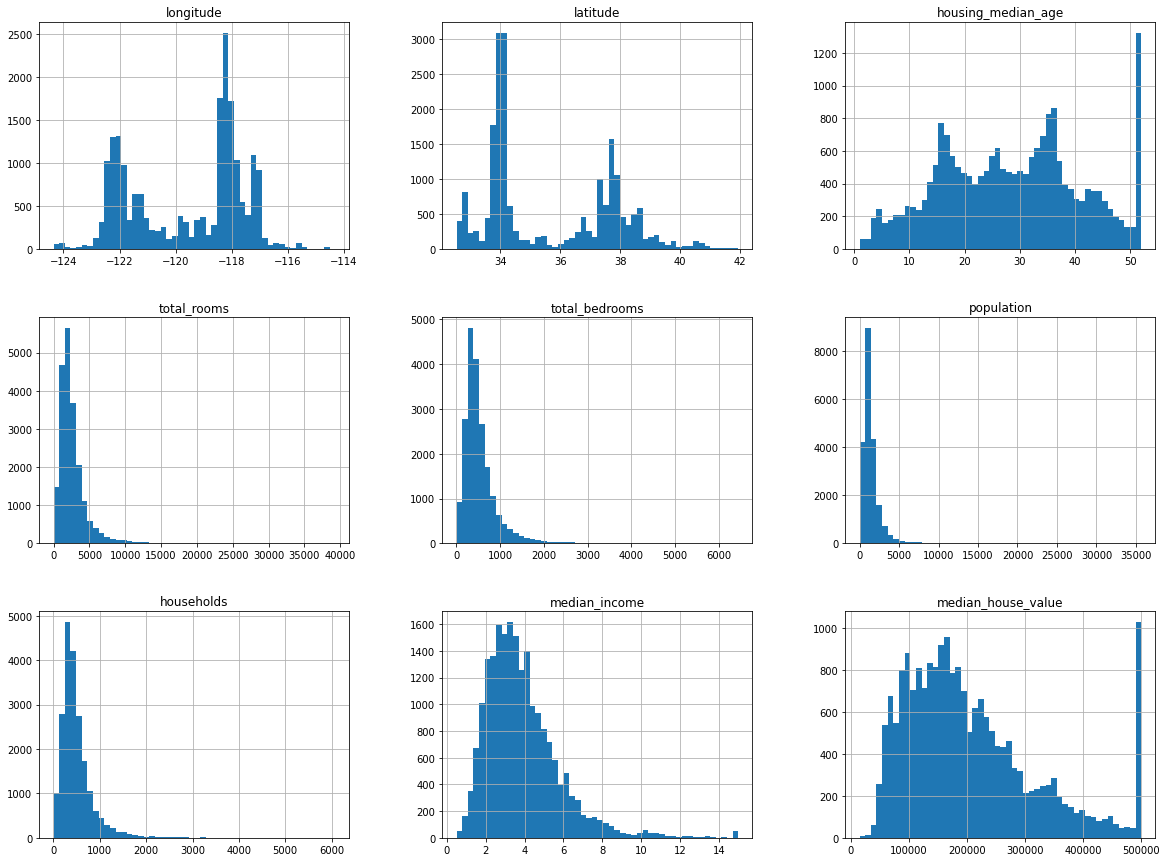

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
# Create the test set
import numpy as np

# Splitting strategy 1: Shuffle. (Con: cannot handle new data.) 
def split_train_set(data, test_ratio=0.2):
    shuffled_indicies = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indicies[:test_set_size]
    train_indices = shuffled_indicies[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_set(housing, 0.2)
print("{} training datapoints, {} test datapoints".format(len(train_set), len(test_set)))

import hashlib

# Splitting strategy 2: Split by identifiers (Indexed Identifier Hash vs. Unique Feature Combination)
def test_set_check(identifier, test_ratio, hash_func):
    # Digest the identifier hash and test the last byte.
    return hash_func(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash_func=hashlib.md5):
    ids = data[id_column]
    in_test_set_flags = ids.apply(lambda id: test_set_check(id, test_ratio, hash_func))
    return data.loc[~in_test_set_flags], data.loc[in_test_set_flags]

housing_with_id = housing.reset_index() # Creates a new index column.
train_set, test_set = split_train_test_by_id(housing_with_id, test_ratio=0.2, id_column="index")
print("{} training datapoints, {} test datapoints".format(len(train_set), len(test_set)))

# Con: prone to sampling bias when multiple datapoints end up with the same identifier)
housing_with_id["id"] = housing.longitude * 1000 + housing.latitude
train_set, test_set = split_train_test_by_id(housing_with_id, test_ratio=0.2, id_column="id" )
print("{} training datapoints, {} test datapoints".format(len(train_set), len(test_set)))

# from sklearn.model_selection import train_test_split
# train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


16512 training datapoints, 4128 test datapoints
16362 training datapoints, 4278 test datapoints
16267 training datapoints, 4373 test datapoints


In [15]:
# Stratified Sampling
housing["income_cat"] = np.ceil(housing.median_income / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
# housing.hist(column="income_cat", bins=50, figsize=(20,15))

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
strat_test_set.income_cat.value_counts() / len(strat_test_set)

# Remove incoming category column.
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

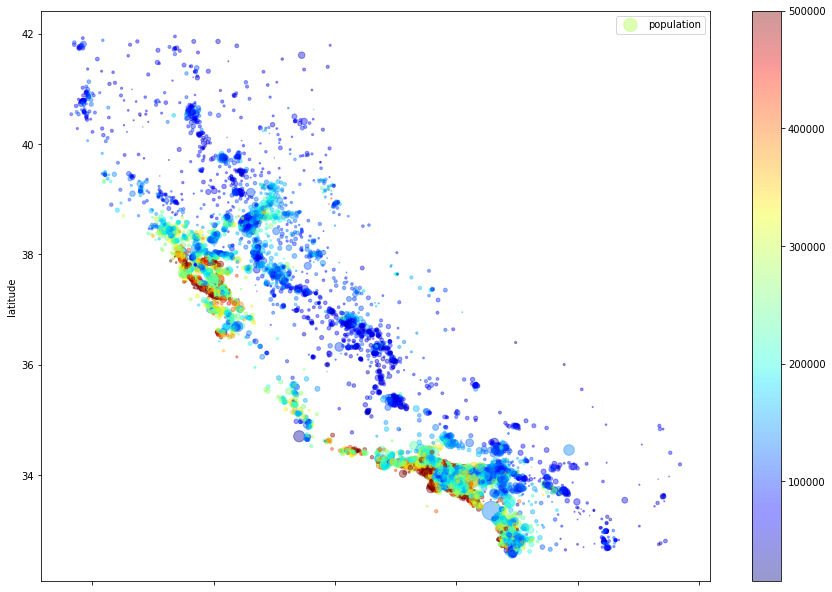

In [16]:
# Visualize and play with a sample or a copy of the training set to gain more insights.
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing.population/100, label="population", figsize=(15,10.5),
            c=housing.median_house_value, cmap=plt.get_cmap("jet"), colorbar=True
            ) # Use more transparent dots to indicate density.
plt.legend()

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

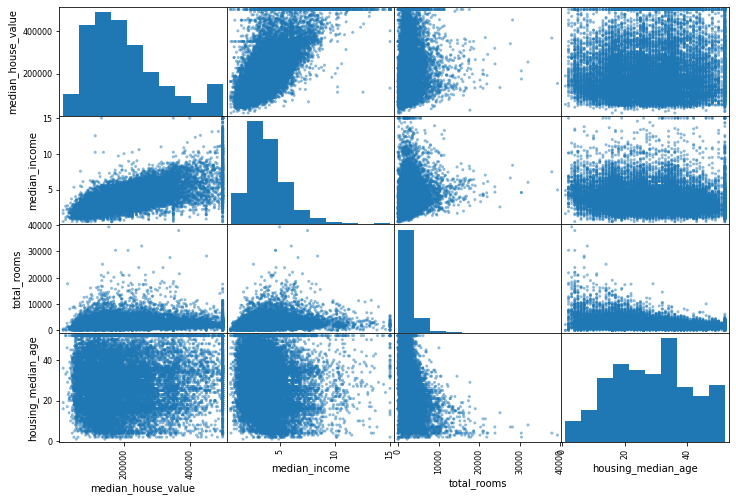

In [17]:
# Look for correlations.
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

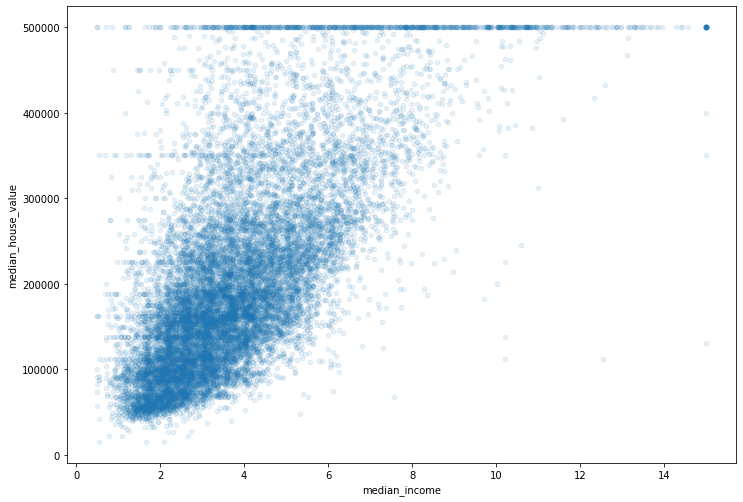

In [18]:
# Focus on the correlation between median_house_value vs. median_income.
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(12, 8.4))

In [19]:
# longitude	latitude	housing_median_age	total_rooms	total_bedrooms
# population	households	median_income	median_house_value	ocean_proximity
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
corr_matrix = housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [20]:
# Prepare the data for meachine learning algorithms
housing = strat_train_set.

SyntaxError: invalid syntax (<ipython-input-20-79d478df1636>, line 2)